# 1. 시계열 분석: 머신러닝 기법




- Time series로 X, y 생성하기

In [ ]:
import pandas as pd
import numpy as np

In [ ]:
def make_sequence(time_series, n):  #시계열에서 1부터 n번째까지 선택해서 x로 지정, n+1번째값은 y, 이런 식으로 시계열 값을 계속 윈도우 n크기로 슬라이딩
    x_train, y_train = list(), list()

    for i in range(len(time_series)):
        x = time_series[i:(i + n)]
        if (i + n) < len(time_series):
            x_train.append(x)
            y_train.append(time_series[i + n])
        else:
            break

    return np.array(x_train), np.array(y_train)


In [ ]:
# amazon.com의 close 컬럼을 사용하여 sequence를 만들기 (make_sequence, time step=....
data = pd.read_csv("AMZN.csv")
x_train, y_train = make_sequence( data.Close.values, 3)
x_train = x_train.reshape( -1, 3, 1)
y_train = y_train.reshape( -1, 1)

# 1.5 처음부터225개까지가 train, 226~252까지 test
x_train2 = x_train[ : 225]
y_train2 = y_train[ : 225]
x_test = x_train[ 225: ]
y_test = y_train[ 225: ]

In [ ]:
datapct=data.Close.pct_change()   #주가인 경우 수익율
logreturn=np.log(1+datapct) #로그수익율
logreturn.head()
print(logreturn.describe())


count    251.000000
mean       0.001019
std        0.019030
min       -0.082535
25%       -0.007880
50%        0.000514
75%        0.008992
max        0.071196
Name: Close, dtype: float64


In [ ]:
#로그 수익율에 대해 적용
logr1=logreturn.values
logr=logr1.reshape(1,-1)
inte=13 #pacf의 p값
x=[]
y=[]
for i in range(logr.shape[1]):
    if i+inte>logr.shape[1]-1:
        break
    else:
         xx=logr[0,i:i+inte]
         x.append(xx)
         yy=logr[0,i+inte]
         y.append(yy)
x=np.array(x)
y=np.array(y)
x_train=x[:100]
x_test=x[100:]
y_train=y[:100]
y_test=y[100:]

In [ ]:
import numpy as np
import pandas as pd
import yfinance as yf

AMZN = yf.download('AMZN', start="2020-01-01", end="2023-12-31")

AMZN = AMZN.round(2)

[*********************100%***********************]  1 of 1 completed


In [ ]:
AMZN

Price,Close,High,Low,Open,Volume
Ticker,AMZN,AMZN,AMZN,AMZN,AMZN
Date,,,,,
2020-01-02,94.90,94.90,93.21,93.75,80580000
2020-01-03,93.75,94.31,93.22,93.22,75288000
2020-01-06,95.14,95.18,93.00,93.00,81236000
2020-01-07,95.34,95.69,94.60,95.22,80898000
2020-01-08,94.60,95.55,94.32,94.90,70160000
...,...,...,...,...,...
2023-12-22,153.42,154.35,152.71,153.77,29480100
2023-12-26,153.41,153.98,153.03,153.56,25067200


In [ ]:
AMZN['Close']["AMZN"].values

array([ 94.9 ,  93.75,  95.14, ..., 153.34, 153.38, 151.94])

In [ ]:
n = 5
x, y = make_sequence(AMZN['Close']["AMZN"].values, n)
x = x.reshape(-1, n, 1)
y = y.reshape(-1, 1)

In [ ]:
print(x.shape)
print(y.shape)

(1001, 5, 1)
(1001, 1)


In [ ]:
test_len = 750
x_train = x[:test_len]
y_train = y[:test_len]
x_test = x[test_len:]
y_test = y[test_len:]

print('train:', x_train.shape, y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (750, 5, 1) (750, 1)
test: (251, 5, 1) (251, 1)


- ML Regression으로 모델링

- RMSE로 확인

- 참고: LSTM

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
series = scaler.fit_transform( AMZN['Close'])
series.shape

(1006, 1)

In [ ]:
n = 5
x, y = make_sequence(series.reshape(1006), n)
x = x.reshape(-1, n, 1)
y = y.reshape(-1, 1)

In [ ]:
print(x.shape)
print(y.shape)

(1001, 5, 1)
(1001, 1)


In [ ]:
test_len = 750
x_train = x[:test_len]
y_train = y[:test_len]
x_test = x[test_len:]
y_test = y[test_len:]

print('train:', x_train.shape, y_train.shape)
print('test:',x_test.shape, y_test.shape)

train: (750, 5, 1) (750, 1)
test: (251, 5, 1) (251, 1)


In [ ]:
from tensorflow.keras.layers import Dense, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import SGD

LSTM_model = Sequential()
LSTM_model.add(LSTM(units = 50, activation = 'tanh', input_shape = (n, 1), return_sequences=True))
LSTM_model.add(LSTM(units = 50, activation = 'tanh'))
LSTM_model.add(Dense(1, activation = 'linear'))

LSTM_model.compile(optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=False), loss = 'mse')  #mean squared error
LSTM_model.fit(x_train, y_train, epochs=50, batch_size=150)

Epoch 1/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.3587
Epoch 2/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0990
Epoch 3/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1089
Epoch 4/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.1034 
Epoch 5/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0590
Epoch 6/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0684
Epoch 7/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0630
Epoch 8/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0507
Epoch 9/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0506
Epoch 10/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0481
Epoch 11/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0425
Epoch 12/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0440
Epoch 13/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0404
Epoch 14/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0380
Epoch 15/50
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 0.0350
Epoch 16/50
5/5 ━━━━━━━━━━━━━━━━━

In [ ]:
pred = LSTM_model.predict(x_test)
pred

8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


array([[0.02163028],
       [0.02137593],
       [0.02082724],
       [0.02548689],
       [0.03029528],
       [0.0322215 ],
       [0.03712642],
       [0.04274443],
       [0.05823571],
       [0.08225027],
       [0.10520439],
       [0.12516099],
       [0.13825355],
       [0.13732262],
       [0.13851574],
       [0.13586602],
       [0.13738616],
       [0.14086314],
       [0.1504916 ],
       [0.15757999],
       [0.16484326],
       [0.1776258 ],
       [0.1922196 ],
       [0.21347272],
       [0.22293091],
       [0.230627  ],
       [0.22939745],
       [0.21968758],
       [0.1904712 ],
       [0.17921874],
       [0.17175074],
       [0.16572964],
       [0.16662966],
       [0.16901776],
       [0.16996156],
       [0.1622363 ],
       [0.15328202],
       [0.14141726],
       [0.13351712],
       [0.1267323 ],
       [0.12545449],
       [0.11940159],
       [0.11223735],
       [0.11262001],
       [0.11271115],
       [0.11181   ],
       [0.11543655],
       [0.117

In [ ]:
pred_range = np.arange(len(y_train), len(y_train) + len(pred))

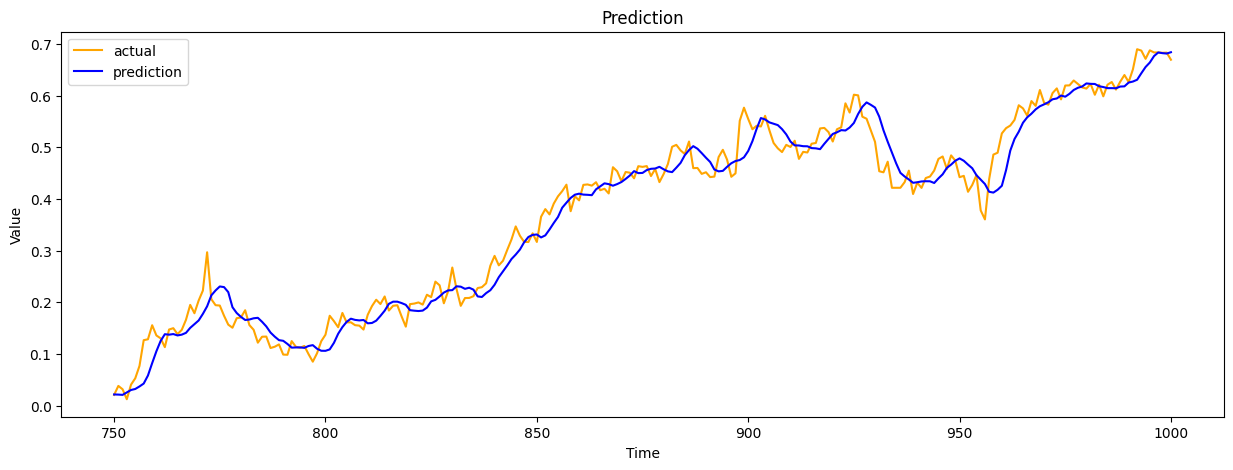

In [ ]:
from matplotlib import pyplot as plt
plt.figure(figsize=(15,5))
plt.title('Prediction')
plt.xlabel('Time'); plt.ylabel('Value')
plt.plot(pred_range, y_test.reshape(-1,), color='orange', label='actual')
plt.plot(pred_range, pred.reshape(-1,), color='blue', label='prediction')
plt.legend()
plt.show()

#2. 다양한 시계열 예측 기법 비교
##1. SARIMAX (Seasonal AutoRegressive Integrated Moving Average with eXogenous variables)
- ARIMA의 확장
- seasonal, non-seasonal data 처리 가능
- X변수 적용 가능
- 중소규모 데이터에 적절
- 모형 파라미터 해석 및 계절적 패턴이 분명할 경우 모델링 성능 우수
- Careful parameter tuning (e.g., p, d, q, P, D, Q).
- Linear relationships 가정: 대규모 데이터 및 비선형 트렌드에서는 성능 저하

##2. RNN (Recurrent Neural Networks)
- neural network: 순차적인 데이터를 처리(기존 입력값에 대한 memory), 시계열에 활용
- temporal dependencies를 활용
- univariate & multivariate time series에 활용
- 비선형 패턴/복잡한 패턴 모델링
- long-term dependency : vanishing gradient problems
- 통계 모형 대비 해석이 어려움





- memory cell을 통해서 long sequence에 대한 정보를 유지
- noisy data, long term dependency 처리
- 다른 모형과 같이 사용
- 계산 비용
- 데이터가 많아야 피팅이 좋음

##3.Prophet
- open-source forecasting tool developed by Facebook
- 결측, 이상치, 계절성이 강한 시계열 데이터에 활용
- 사용이 편하며, 파라미터 튜닝이 필요없음
- 비즈니스 예측 등에 많이 활용: 소매 판매, 웹트래픽 등

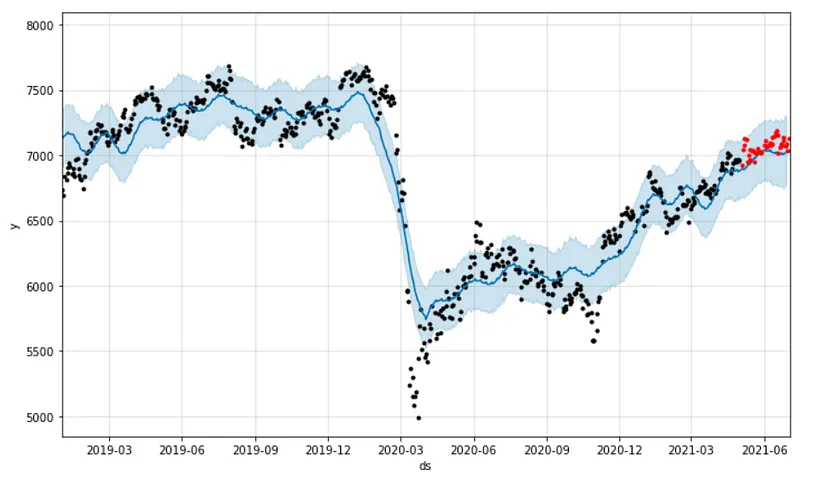

- 자동으로 결측 및 이상치 처리
- 일별/주별/연간 계절성 처리
- 사용이 편리
- 계절성 외 비선형 패턴 처리에 약함

##4.Transformer Models
- Transformer models: suquential data 처리가 우수하여 시계열 예측에 적용
 - self-attention mechanisms: 입력 sequence의 각각 다른 파트에 집중
 - energy load forecasting, anomaly detection, other applications에 활용
 - 우수한 성능 및 sequence의 dependency를 잘 처리.

### 예: TimesFM (Foundation Model)
- TimesFM : decoder-only transformer
- Patched-Decoder Style
 - NLP의 토큰 대신 Patch 사용: TimesLM은 시계열 데이터를 patch 단위로 나눔
 - patch: 시계열 값들의 세그먼트, 각 patch가 토큰의 역할
 - 1024개 값의 시계열이 32개 길이의 패치로 나눠질 수 있음, 32개 패치를 처리
 - 토큰의 수를 Transformer 은닉층으로 줄이며 계산

- Flexible Input and Output Patch Lengths
 - Input patches로 입력 시계열의 context를 파악, output patch로는 미래 값을 예측
 - 긴 미래 시점의 값을 예측할 수 있음(예: 128개 값의 예측)
 - 일반화 전략: random masking during training, 패치에 대한 drop out과 같으며, 다양한 context 길이에 모형의 적응력을 높임

- Stacked Transformer Layers
 - self-attention and feedforward networks의 조합
 - causal attention을 통해서 과거 데이터에 의존한 미래 패치의 값을 예측

- 시계열 처리
 - Positional encoding: temporal적인 면을 인식, 시계열 데이터 처리를 지원

- 학습: data diveristy, efficient Processing
 - 다양한 데이터로 미리 학습: 현실 데이터와 현실 데이터 합성을 통해 다양성
 - Google Trends, Wiki Pageviews, Synthetic Data(ARMA processes, seasonal patterns,  step functions 등 포함)

 - Patched Input Processing: 시계열 데이터가 non-overlapping patches로 나눠지며, 각 패치는 임베딩으로 변환
 - Masking During Training: 다양한 context 길이를 지원하기 위한 랜덤 마스킹
 - Loss Function: MSE

- Dataset Mixing Strategy
 - 50–50 split between real and synthetic data.
 - 실제 데이터에 대해서는 가중치가 일별/주별/월별 데이터셋에 동일하게 적용

- zero-shot forecasting ability
 — 학습하지 않았던 데이터에 대해 좋은 성능이 나옴

- Scaling Laws
 - model size, data volume, training compute에 영향
 - NLP와 같이, parameter count와 forecasting accuracy 관계가 있음
 - 예: 17M, 70M, 200M parameters로 학습 시 결과가 지속적으로 개선


##  Prophet과 ARIMA, ML 비교

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf
from prophet import Prophet
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [ ]:
import warnings
warnings.filterwarnings('ignore')

import logging
cmdstanpy_logger = logging.getLogger("cmdstanpy")
absl_logger = logging.getLogger("absl")
cmdstanpy_logger.disabled = True
absl_logger.disabled = True

In [ ]:
# Data loading
temps = pd.read_csv('daily-min-temperatures.csv')

In [ ]:
# Conversion of date to datetime format
temps['ds'] = pd.to_datetime(temps['Date'])
temps.drop(columns=['Date'], inplace=True)
temps.rename(columns={'Temp': 'y'},inplace=True)

In [ ]:
temps['y'].astype("str").str.replace("?", "0").astype(float)
temps.head()

,y,ds
0,20.7,1981-01-01
1,17.9,1981-01-02
2,18.8,1981-01-03
3,14.6,1981-01-04
4,15.8,1981-01-05


In [ ]:
# Plotting the evolution of the temperature
fig = px.line(temps, x='ds', y='y')
fig.update_layout(
    title='Evolution of the temperature',
    xaxis_title='Date',
    yaxis_title='Temperature'
)

In [ ]:
temps['y'].describe()

,y
count,3650.000000
mean,11.177753
std,4.071837
min,0.000000
25%,8.300000
50%,11.000000
75%,14.000000
max,26.300000


In [ ]:
nb_missing_timestamps = len(pd.date_range( start=temps['ds'].min(), end=temps['ds'].max()).difference(temps.ds))
print(str(nb_missing_timestamps) + ' missings timestamps')

2 missings timestamps


In [ ]:
missing_dates = pd.date_range(start=temps['ds'].min(), end=temps['ds'].max(), freq='D').difference(temps['ds'])
missing_data = {'ds': missing_dates, 'y': [pd.NA]*len(missing_dates)}
missing_df = pd.DataFrame(missing_data)

temps = pd.concat([temps, missing_df]).sort_values(by='ds').reset_index(drop=True)
temps['y'] = temps['y'].fillna(method='ffill')

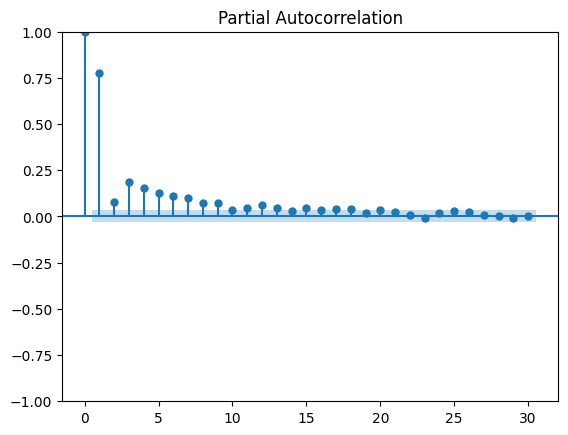

In [ ]:
plot_pacf(temps.y,lags = 30);

In [ ]:
# Add of the week of the day and the month of the year information
temps['weekday'] = temps['ds'].dt.weekday
temps['month'] = temps['ds'].dt.month

<Axes: xlabel='weekday', ylabel='y'>

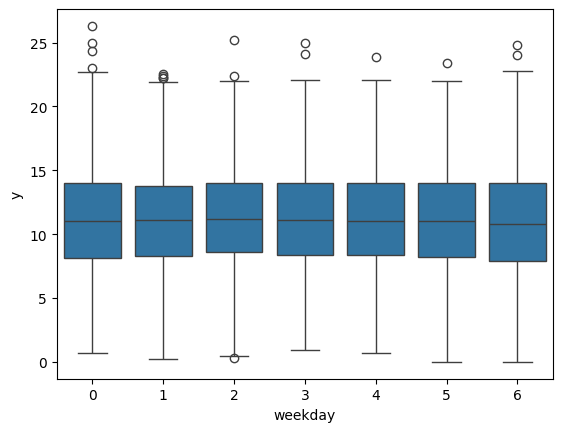

In [ ]:
sns.boxplot(x="weekday", y="y", data=temps)

<Axes: xlabel='month', ylabel='y'>

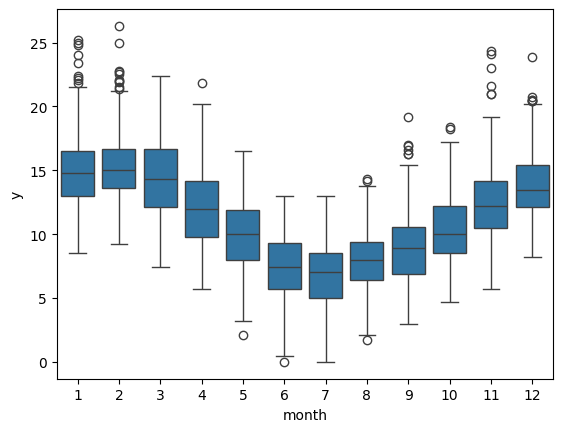

In [ ]:
sns.boxplot(x="month", y="y", data=temps)

In [ ]:
temps.shape
temps.head()

,y,ds,weekday,month
0,20.7,1981-01-01,3,1
1,17.9,1981-01-02,4,1
2,18.8,1981-01-03,5,1
3,14.6,1981-01-04,6,1
4,15.8,1981-01-05,0,1


In [ ]:
temps['lag_1'] = temps['y'].shift(1).fillna(0)
temps['lag_7'] = temps['y'].shift(7).fillna(0)

In [ ]:
temps

,y,ds,weekday,month,lag_1,lag_7
0,20.7,1981-01-01,3,1,0.0,0.0
1,17.9,1981-01-02,4,1,20.7,0.0
2,18.8,1981-01-03,5,1,17.9,0.0
3,14.6,1981-01-04,6,1,18.8,0.0
4,15.8,1981-01-05,0,1,14.6,0.0
...,...,...,...,...,...,...
3647,14.0,1990-12-27,3,12,14.6,15.4
3648,13.6,1990-12-28,4,12,14.0,13.1
3649,13.5,1990-12-29,5,12,13.6,13.2
3650,15.7,1990-12-30,6,12,13.5,13.9


In [ ]:
#window size
window_size=3000
step_size=14
train_data = temps[0 : window_size]
test_data = temps[window_size :]

In [ ]:
model = ARIMA(train_data['y'], order=(7, 1, 0))
model_fit = model.fit()
predicted_arima = model_fit.forecast(steps=step_size)

In [ ]:
model_prophet = Prophet( yearly_seasonality=False, weekly_seasonality=False, daily_seasonality=True)
model_prophet_fit = model_prophet.fit( train_data)
predicted_df = model_prophet_fit.make_future_dataframe(periods=step_size)
predicted_prophet = model_prophet_fit.predict(predicted_df)
predicted_prophet['yhat'].tail(step_size)

,yhat
3000,13.303089
3001,13.306923
3002,13.310757
3003,13.314591
3004,13.318425
3005,13.322259
3006,13.326093
3007,13.329927
3008,13.333761
3009,13.337595


In [ ]:
model_lr = LinearRegression()
model_lr_fit = model_lr.fit(train_data[['lag_1', 'lag_7', 'weekday', 'month']], train_data['y'])
predicted_lr = model_lr_fit.predict(test_data[['lag_1', 'lag_7', 'weekday', 'month']])

In [ ]:
model_rf = RandomForestRegressor()
model_rf_fit = model_rf.fit(train_data[['lag_1', 'lag_7', 'weekday', 'month']], train_data['y'])
predicted_rf = model_rf_fit.predict(test_data[['lag_1', 'lag_7', 'weekday', 'month']])

#비교

In [ ]:
predicted_arima

,predicted_mean
3000,15.029236
3001,14.406207
3002,14.239640
3003,14.184614
3004,14.130115
3005,13.975117
3006,14.023072
3007,14.236916
3008,14.302677
3009,14.248663


In [ ]:
predicted_prophet

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,daily,daily_lower,daily_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,1981-01-01,19.064686,7.648263,17.796533,19.064686,19.064686,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.604648
1,1981-01-02,19.061108,7.356907,17.797917,19.061108,19.061108,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.601071
2,1981-01-03,19.057531,7.078178,17.429292,19.057531,19.057531,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.597493
3,1981-01-04,19.053953,7.551678,17.656394,19.053953,19.053953,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.593916
4,1981-01-05,19.050376,7.494072,17.705657,19.050376,19.050376,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,12.590338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3009,1989-03-29,19.797633,8.288511,18.744100,19.797633,19.797633,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.337595
3010,1989-03-30,19.801467,8.504381,18.384298,19.801467,19.801467,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.341429
3011,1989-03-31,19.805301,7.726695,18.440023,19.805301,19.805301,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.345263
3012,1989-04-01,19.809135,8.471382,18.937626,19.809135,19.809135,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,-6.460037,0.0,0.0,0.0,13.349097


In [ ]:
predicted_lr

array([14.25491609, 15.999318  , 16.075885  , 15.73926563, 14.95410086,
       13.08851606, 13.21769381, 11.30135123, 11.36368437, 12.77426736,
       11.74325343, 10.7428696 , 12.50789067, 12.27608861, 13.71010104,
       13.47482978, 13.19514588, 16.33567948, 12.44253966, 13.58096811,
       12.33559064, 13.72906382, 13.42694794, 15.43917967, 13.3385575 ,
       13.64241508, 12.4815853 ,  9.88494009, 11.95857396, 11.90100039,
       12.34719665, 10.08265934, 10.11868709,  9.71738545, 10.57546125,
       10.45420288,  9.61597603, 10.77296307, 11.39771254, 12.84883477,
       14.10198969, 13.13696486, 12.20779054, 13.29531927, 13.67638194,
       12.15281418, 14.14090289, 11.2389065 , 10.91048523, 11.641905  ,
       11.4747852 , 10.2936858 , 12.6837449 , 12.74738488, 12.03208261,
       11.55226903, 11.39952504, 10.06703332,  9.62257875,  9.65946203,
       11.82439291, 11.58223038,  8.68626974,  7.17018652, 10.71787075,
        9.65537121, 10.04030727, 10.97473265,  9.09018507,  9.46

In [ ]:
predicted_rf

array([14.295     , 16.01      , 16.37      , 16.22      , 15.586     ,
       13.638     , 13.907     , 10.51      , 10.845     , 12.537     ,
       11.612     , 12.305     , 10.724     , 12.551     , 13.787     ,
       13.787     , 12.32      , 17.796     , 11.316     , 12.91      ,
       11.916     , 11.73      , 12.401     , 13.443     , 12.723     ,
       14.33      , 11.356     ,  9.539     ,  9.924     , 11.487     ,
       12.776     ,  9.659     ,  9.955     ,  8.774     , 11.621     ,
       10.911     ,  9.058     , 11.379     , 11.822     , 12.838     ,
       12.605     , 14.554     , 10.606     , 13.846     , 13.633     ,
       10.902     , 12.82      ,  9.835     ,  9.623     ,  9.047     ,
        9.717     , 11.018     , 11.276     , 13.425     , 10.229     ,
       11.526     , 10.32      ,  9.952     ,  7.572     ,  9.563     ,
       11.322     , 11.104     ,  7.716     ,  7.365     , 10.317     ,
        9.562     ,  7.293     , 11.064     ,  9.011     ,  9.54

In [ ]:
mean_squared_error( test_data['y'], predicted_rf)

5.6113810447672705

In [ ]:
mean_squared_error( test_data['y'], predicted_lr)

5.309226160847855

In [ ]:
mean_squared_error( test_data.y[0:14], predicted_prophet.trend[3000:3014])

49.86793560121531

In [ ]:
mean_squared_error( test_data.y[0:14], predicted_arima)

8.228847185336747

#3.DB의 테이블 읽어서 시계열 분석
- 유럽 국가별 전력 수요: https://data.open-power-system-data.org/time_series/

In [ ]:
!wget https://data.open-power-system-data.org/time_series/2020-10-06/time_series.sqlite

--2025-07-03 18:05:09--  https://data.open-power-system-data.org/time_series/2020-10-06/time_series.sqlite
Resolving data.open-power-system-data.org (data.open-power-system-data.org)... 85.13.131.68
Connecting to data.open-power-system-data.org (data.open-power-system-data.org)|85.13.131.68|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 226308096 (216M) [application/vnd.sqlite3]
Saving to: ‘time_series.sqlite’

time_series.sqlite  100%[===================>] 215.82M  18.4MB/s    in 13s     

2025-07-03 18:05:23 (16.6 MB/s) - ‘time_series.sqlite’ saved [226308096/226308096]



In [ ]:
import sqlite3

# SQLite DB 파일 생성 (없으면 새로 생성됨)
conn = sqlite3.connect("time_series.sqlite")

# 커서 생성
cursor = conn.cursor()
cursor.execute("SELECT name FROM sqlite_master WHERE type='table';")
tables = cursor.fetchall()

print("DB에 있는 테이블:")
for t in tables:
    print("-", t[0])

DB에 있는 테이블:
- time_series_15min_singleindex
- time_series_30min_singleindex
- time_series_60min_singleindex


In [ ]:
# 테이블을 DataFrame으로 읽기
import pandas as pd
df = pd.read_sql("SELECT * FROM time_series_60min_singleindex", conn)

print(df.head())  # 데이터 일부 확인
conn.close()


          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [ ]:
df.shape

(50401, 300)

In [ ]:
df["AT_load_actual_entsoe_transparency"] #오스트리아 전체 전력 수요

,AT_load_actual_entsoe_transparency
0,NaN
1,5946.0
2,5726.0
3,5347.0
4,5249.0
...,...
50396,6661.0
50397,6336.0
50398,5932.0
50399,5628.0
